<a href="https://colab.research.google.com/github/MarkAshtonSmith/Colab-GAME/blob/main/sdt_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-1792460552.py:92: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_num = np.trapz(tprs_sorted, fprs_sorted)


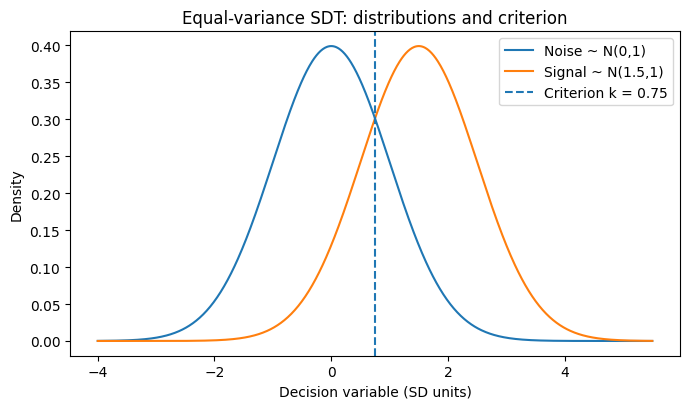

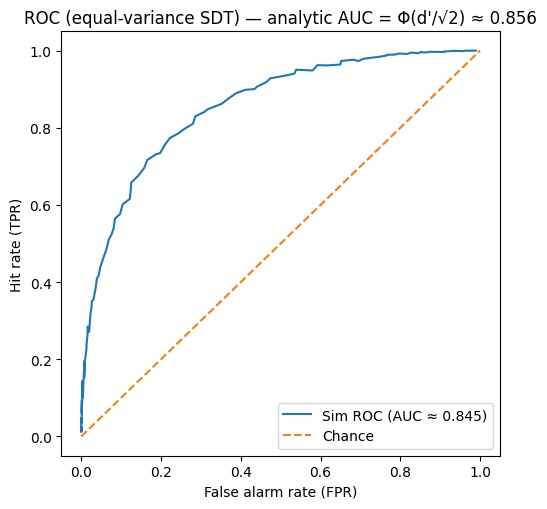

=== SDT summary from simulated trials ===
Trials: signal=5000, noise=5000
True d'      : 1.500 | Criterion shift c: 0.000 (k = d'/2 + c = 0.750)
Observed H   : 0.776 | FA: 0.216
Estimated d' : 1.543
Estimated c  : 0.014
Estimated beta (LR): 1.022
ROC AUC      : numeric=0.845 | analytic=0.856


In [1]:
# SDT simulation (equal-variance Gaussian model)
# UoEO Computational Psychology Lab — Signal Detection use case
# -------------------------------------------------------------
# What this cell does:
# 1) Simulates noise ~ N(0,1) and signal ~ N(d',1)
# 2) Applies a decision criterion k (k = d'/2 + c) to generate hits/FAs
# 3) Estimates SDT metrics (d', c, beta) from simulated data using log-linear correction
# 4) Sweeps the criterion to draw an ROC curve (numeric AUC) and compares to analytic AUC
# 5) Plots the distributions + criterion, and the ROC curve
#
# Notes
# - d' is computed from z(H) - z(FA) under equal-variance SDT.
# - c = -0.5 * (z(H) + z(FA)); beta = exp(d' * c) (likelihood ratio form).
# - Analytic AUC (equal-variance binormal) = Φ(d'/√2).

# --------- deps
!pip -q install numpy pandas matplotlib scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# --------- reproducibility
RNG = np.random.default_rng(42)

# --------- core helpers
def loglinear_rate(x, n):
    """
    Log-linear correction (Stanislaw & Todorov, 1999):
    Add 0.5 to each cell -> H' = (H* + 0.5)/(n + 1) to avoid 0 or 1 rates.
    Here x is the count of "yes" out of n.
    """
    return (x + 0.5) / (n + 1.0)

def sdt_from_counts(hits, misses, fas, crs):
    """Return SDT metrics given counts, with log-linear correction."""
    ns = hits + misses
    nn = fas + crs

    H  = loglinear_rate(hits, ns)
    FA = loglinear_rate(fas,  nn)

    zH, zFA = norm.ppf(H), norm.ppf(FA)
    dprime  = zH - zFA                               # sensitivity
    c       = -0.5 * (zH + zFA)                      # criterion (bias)
    beta    = float(np.exp(dprime * c))              # likelihood ratio measure

    return {
        "H": float(H), "FA": float(FA),
        "zH": float(zH), "zFA": float(zFA),
        "dprime_hat": float(dprime),
        "c_hat": float(c),
        "beta_hat": beta
    }

def simulate_trials(n_signal=5000, n_noise=5000, dprime_true=1.5, c_shift=0.0, rng=RNG):
    """
    Simulate signal/noise samples and apply decision criterion.
    Under equal-variance SDT: noise ~ N(0,1), signal ~ N(d',1).
    Criterion in raw units: k = d'/2 + c_shift  (c_shift>0 = conservative).
    """
    noise   = rng.normal(loc=0.0,       scale=1.0, size=n_noise)
    signal  = rng.normal(loc=dprime_true, scale=1.0, size=n_signal)
    k       = dprime_true/2.0 + c_shift

    hits    = int(np.sum(signal >= k))
    misses  = n_signal - hits
    fas     = int(np.sum(noise  >= k))
    crs     = n_noise  - fas

    return dict(
        noise=noise, signal=signal, k=k,
        counts=dict(hits=hits, misses=misses, fas=fas, crs=crs)
    )

def roc_curve_equalvar(dprime_true, n_signal=5000, n_noise=5000, c_grid=np.linspace(-3, 3, 121), rng=RNG):
    """Sweep c_shift to trace ROC from simulated samples."""
    tprs, fprs = [], []
    for c_shift in c_grid:
        sim = simulate_trials(n_signal, n_noise, dprime_true, c_shift, rng)
        h, m, f, r = sim["counts"]["hits"], sim["counts"]["misses"], sim["counts"]["fas"], sim["counts"]["crs"]
        ns, nn = h+m, f+r
        # raw rates (no loglinear for ROC plotting)
        H, FA = h/ns, f/nn
        tprs.append(H)
        fprs.append(FA)
    # numeric AUC via trapezoid (sorted by FPR)
    order = np.argsort(fprs)
    fprs_sorted = np.array(fprs)[order]
    tprs_sorted = np.array(tprs)[order]
    auc_num = np.trapz(tprs_sorted, fprs_sorted)
    return fprs_sorted, tprs_sorted, float(auc_num)

def analytic_auc_equalvar(dprime_true):
    """Closed form AUC for equal-variance binormal ROC."""
    return float(norm.cdf(dprime_true / np.sqrt(2.0)))

# --------- run a demo
# Parameters you can tweak
N_SIGNAL   = 5000
N_NOISE    = 5000
DPRIME     = 1.5     # true separation in SD units
C_SHIFT    = 0.0     # >0 = conservative; <0 = liberal

sim = simulate_trials(N_SIGNAL, N_NOISE, dprime_true=DPRIME, c_shift=C_SHIFT, rng=RNG)
metrics = sdt_from_counts(**sim["counts"])

# ROC
fpr, tpr, auc_num = roc_curve_equalvar(DPRIME, N_SIGNAL, N_NOISE, rng=RNG)
auc_ana = analytic_auc_equalvar(DPRIME)

# --------- plots
# 1) Distributions + criterion
xs = np.linspace(-4, 4 + DPRIME, 800)
noise_pdf  = norm.pdf(xs, loc=0.0,        scale=1.0)
signal_pdf = norm.pdf(xs, loc=DPRIME,     scale=1.0)

plt.figure(figsize=(7,4.2))
plt.plot(xs, noise_pdf,  label="Noise ~ N(0,1)")
plt.plot(xs, signal_pdf, label=f"Signal ~ N({DPRIME},1)")
plt.axvline(sim["k"], linestyle="--", label=f"Criterion k = {sim['k']:.2f}")
plt.title("Equal-variance SDT: distributions and criterion")
plt.xlabel("Decision variable (SD units)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# 2) ROC
plt.figure(figsize=(5.2,5.2))
plt.plot(fpr, tpr, label=f"Sim ROC (AUC ≈ {auc_num:.3f})")
plt.plot([0,1],[0,1],'--', label="Chance")
plt.title(f"ROC (equal-variance SDT) — analytic AUC = Φ(d'/√2) ≈ {auc_ana:.3f}")
plt.xlabel("False alarm rate (FPR)")
plt.ylabel("Hit rate (TPR)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# --------- summary
print("=== SDT summary from simulated trials ===")
print(f"Trials: signal={N_SIGNAL}, noise={N_NOISE}")
print(f"True d'      : {DPRIME:.3f} | Criterion shift c: {C_SHIFT:.3f} (k = d'/2 + c = {sim['k']:.3f})")
print(f"Observed H   : {metrics['H']:.3f} | FA: {metrics['FA']:.3f}")
print(f"Estimated d' : {metrics['dprime_hat']:.3f}")
print(f"Estimated c  : {metrics['c_hat']:.3f}")
print(f"Estimated beta (LR): {metrics['beta_hat']:.3f}")
print(f"ROC AUC      : numeric={auc_num:.3f} | analytic={auc_ana:.3f}")
